In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm
import argparse
from PIL import Image
from torch.nn import functional as F
import os

def parse_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--lr",type=float,default=0.078)
    parser.add_argument("--seed",type=int,default=5319)
    parser.add_argument("--batchsize",type=int,default=256)

    parser.add_argument("--dataset_dir",type=str,default=r"./DATASETS/classify_leaves")
    parser.add_argument("--checkpoint_dir",type=str,default=r"./CHECK_POINT")
    parser.add_argument("--checkpoint_name",type=str,default=r"classify_leaves.pt")
    
    parser.add_argument("--epoch",type=int,default=25)
    parser.add_argument("--device",type=str,default="cuda")
    
    arg = parser.parse_args(args=[])
    return arg

args = parse_arg()
checkpoint_path = args.checkpoint_dir + '/' + args.checkpoint_name
device = torch.device(args.device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

In [2]:
class Leaves_Dataset(data.Dataset):
    def __init__(self,path,mode) -> None:
        super().__init__()
        self.mode = mode       
        self.ratio = 4/5
        if self.mode not in ['train','dev','test']:
            raise ValueError
        if self.mode in ['train', 'dev']:
            with open(path,'r') as fp:
                self.all_sample = pd.read_csv(fp)
                self.all_sample_name  = self.all_sample['image']
                self.all_sample_label = self.all_sample['label']

                self.label_class = sorted(set(self.all_sample_label))
                self.onehot = torch.zeros(len(self.label_class))
                self.len = len(self.all_sample_name)
                
                self.train_len = int(self.ratio*self.len)
                self.dev_len   = self.len - self.train_len

                self.train_name  = self.all_sample_name[0:self.train_len]
                self.train_label = self.all_sample_label[0:self.train_len]

                self.dev_name = self.all_sample_name[self.train_len:self.len].reset_index(drop=True)
                self.dev_label = self.all_sample_label[self.train_len:self.len].reset_index(drop=True)
        else:
            with open(path,'r') as fp:
                self.test = pd.read_csv(fp)
                self.test_name  = self.test['image']
                self.len = len(self.test_name)
        self.train_trans = transforms.Compose(
            [
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
             ]
        )    
        self.trans = transforms.Compose(
            [
                        transforms.ToTensor(),
             ]
        )
    def __getitem__(self, index):
        if self.mode in ['train', 'dev']:
            # For training
            if self.mode == 'train':
                file_name = args.dataset_dir+'/'+self.train_name[index]
                image = Image.open(file_name)
                data  = self.train_trans(image)
                label_embed = self.onehot.clone()
                label_embed[self.label_class.index(self.train_label[index])] = 1
                return data, label_embed
            if self.mode == 'dev':
                file_name = args.dataset_dir+'/'+self.dev_name[index]
                image = Image.open(file_name)
                data  = self.trans(image)
                label_embed = self.onehot.clone()
                label_embed[self.label_class.index(self.dev_label[index])] = 1
                return data, label_embed
        else:
            # For testing (no target)
            file_name = args.dataset_dir+'/'+self.test_name[index]
            image = Image.open(file_name)
            data  = self.trans(image)
            return data,self.test_name[index]

    def __len__(self):
        # Returns the size of the dataset
        if self.mode in ['train','dev']:
            if self.mode == 'train':
                return self.train_len
            if self.mode == 'dev':
                return self.dev_len
        else:
            return self.len

train_dataset    = Leaves_Dataset(args.dataset_dir+'/train.csv',mode='train')
train_dataloader = data.DataLoader(train_dataset,args.batchsize,shuffle=True)

dev_dataset    = Leaves_Dataset(args.dataset_dir+'/train.csv',mode='dev')
dev_dataloader = data.DataLoader(dev_dataset,args.batchsize,shuffle=False)

test_dataset    = Leaves_Dataset(args.dataset_dir+'/test.csv',mode='test')
test_dataloader = data.DataLoader(test_dataset,args.batchsize,shuffle=False)

torch.Size([3, 224, 224])


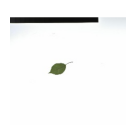

In [3]:
def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    if nrow*ncol == 1:
        axes = [axes, ]
    else:
        axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze().permute(1,2,0))
        ax.set_title('')
        ax.axis('off')
    plt.show()

x,y = next(iter(train_dataset))
print(x.shape)
show_img(x.unsqueeze(0),y,1,1)


In [4]:
class ResNet(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv2d_1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2d_2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,stride=1)
        self.batch_normal_1 = nn.BatchNorm2d(out_channels)
        self.batch_normal_2 = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        self.using_conv1x1 = in_channels != out_channels
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
    def forward(self,x):
        y = F.relu(self.batch_normal_1(self.conv2d_1(x)))
        y = self.batch_normal_2(self.conv2d_2(y))
        if self.using_conv1x1:
            x = self.res_conv(x)
        y = y+x
        return F.relu(y)
    
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResNet(input_channels, num_channels,
                                stride=2))
        else:
            blk.append(ResNet(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net_layer = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 176))

In [5]:
class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = net_layer
    def forward(self,x):
        x = self.net(x)
        return x
    
net = Net()

In [6]:

def accuracy(y_pred,y):
    y_pred = y_pred.softmax(1).argmax(1)
    y = y.argmax(1)
    right = (y_pred == y).sum()
    return (right,y.shape[0])

def train(train_loader,dev_loader,model,n_epoch,lr,device):
    model.to(device)
    if os.path.exists(path=checkpoint_path):
        checkpoint = torch.load(checkpoint_path,map_location=device)
        model.load_state_dict(checkpoint)
        print('find the last checkpoint,load successfully')
    else:
        print('not find the checkpoint')
    optim = torch.optim.SGD(model.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    max_acc = 0
    for epoch in range(n_epoch):
        bar = tqdm(train_loader,total=len(train_loader),unit_scale=args.batchsize)
        model.train()
        for x,y in bar:
            optim.zero_grad()
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optim.step()
            bar.set_description(f'Epoch:[{epoch+1:02d}/{n_epoch}]')
            bar.set_postfix(loss=float(loss))
        right, total = 0, 0
        model.eval()
        with torch.no_grad():
            for x,y in dev_loader:
                model.to(device)
                x,y = x.to(device),y.to(device)
                pred = model(x)
                a,b = accuracy(pred,y)
                right += a
                total += b
        acc = right/total*100
        print("Acc:%.2f%%"%(acc))
        if acc > max_acc:
            torch.save(net.state_dict(),checkpoint_path)
            max_acc = acc
            print("Saving Model")
        else:
            print("No improving")

In [7]:
train(train_dataloader,dev_dataloader,net,args.epoch,args.lr,device)

find the last checkpoint,load successfully


Epoch:[01/25]: 100%|██████████| 14848/14848 [00:43<00:00, 337.80it/s, loss=0.161]


Acc:49.88%
Saving Model


Epoch:[02/25]: 100%|██████████| 14848/14848 [00:41<00:00, 357.24it/s, loss=0.345]


Acc:16.59%
No improving


Epoch:[03/25]: 100%|██████████| 14848/14848 [00:41<00:00, 359.66it/s, loss=0.271]


Acc:49.47%
No improving


Epoch:[04/25]: 100%|██████████| 14848/14848 [00:41<00:00, 359.53it/s, loss=0.243]


Acc:18.77%
No improving


Epoch:[05/25]: 100%|██████████| 14848/14848 [00:41<00:00, 360.38it/s, loss=0.165]


Acc:60.23%
Saving Model


Epoch:[06/25]: 100%|██████████| 14848/14848 [00:41<00:00, 359.91it/s, loss=0.253]


Acc:1.55%
No improving


Epoch:[07/25]: 100%|██████████| 14848/14848 [00:41<00:00, 360.08it/s, loss=0.309]


Acc:15.80%
No improving


Epoch:[08/25]: 100%|██████████| 14848/14848 [00:41<00:00, 360.83it/s, loss=0.15] 


Acc:15.88%
No improving


Epoch:[09/25]: 100%|██████████| 14848/14848 [00:41<00:00, 360.20it/s, loss=0.117] 


Acc:43.67%
No improving


Epoch:[10/25]: 100%|██████████| 14848/14848 [00:41<00:00, 360.29it/s, loss=0.152] 


Acc:48.38%
No improving


Epoch:[11/25]: 100%|██████████| 14848/14848 [00:41<00:00, 358.17it/s, loss=0.175] 


Acc:24.49%
No improving


Epoch:[12/25]: 100%|██████████| 14848/14848 [00:41<00:00, 358.82it/s, loss=0.13]  


Acc:65.05%
Saving Model


Epoch:[13/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.31it/s, loss=0.0965]


Acc:76.76%
Saving Model


Epoch:[14/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.03it/s, loss=0.0889]


Acc:54.10%
No improving


Epoch:[15/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.89it/s, loss=0.0623]


Acc:49.69%
No improving


Epoch:[16/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.52it/s, loss=0.0885]


Acc:30.54%
No improving


Epoch:[17/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.80it/s, loss=0.0433]


Acc:86.65%
Saving Model


Epoch:[18/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.14it/s, loss=0.0619]


Acc:60.58%
No improving


Epoch:[19/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.33it/s, loss=0.083] 


Acc:78.48%
No improving


Epoch:[20/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.20it/s, loss=0.0776]


Acc:81.72%
No improving


Epoch:[21/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.89it/s, loss=0.041] 


Acc:84.69%
No improving


Epoch:[22/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.11it/s, loss=0.0586]


Acc:82.38%
No improving


Epoch:[23/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.11it/s, loss=0.0509]


Acc:81.29%
No improving


Epoch:[24/25]: 100%|██████████| 14848/14848 [00:40<00:00, 367.32it/s, loss=0.0531]


Acc:74.61%
No improving


Epoch:[25/25]: 100%|██████████| 14848/14848 [00:40<00:00, 366.49it/s, loss=0.0262]


Acc:87.20%
Saving Model


In [8]:
right, total = 0, 0
with torch.no_grad():
    net.eval()
    for x,y in train_dataloader:
        net.to(args.device)
        x,y = x.to(args.device),y.to(args.device)
        pred = net(x)
        a,b = accuracy(pred,y)
        right += a
        total += b
print("Acc:%.2f%%"%(right/total*100))

Acc:97.14%


In [9]:
def predict(test_loader,model,device):
    model.to(device)
    bar = tqdm(test_loader,total=len(test_loader),unit_scale=args.batchsize)
    model.eval()
    ans = []
    for x,y in bar:
        x = x.to(device)
        file_name = y
        pred = model(x)
        pred = pred.argmax(1)
        pred_ans = [[name,train_dataset.label_class[target]] for name,target in zip(file_name,pred)]
        ans.extend(pred_ans)
    output = pd.DataFrame(ans,columns=['image','label'])
    output.to_csv('ans.csv',index=False)

predict(test_dataloader,net,args.device)

100%|██████████| 8960/8960 [00:14<00:00, 608.79it/s]
